# Applied Materials 株価（日足）

In [1]:
import sys
import os

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

try:
    __file__
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    from pathlib import Path
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '..'))

from funcs.technical import psar

In [2]:
symbol = 'AMAT'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-09-05 00:00:00-04:00,178.209470,182.887680,177.064810,179.403915,6495000,0.0,0.0
2024-09-06 00:00:00-04:00,178.667327,179.871721,172.585670,173.939362,8887900,0.0,0.0
2024-09-09 00:00:00-04:00,176.278470,177.721741,173.760207,176.726379,7492500,0.0,0.0
2024-09-10 00:00:00-04:00,177.144429,177.681918,173.302335,177.224060,5367900,0.0,0.0
2024-09-11 00:00:00-04:00,179.403898,185.545275,174.596302,185.077454,8187100,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-26 00:00:00-05:00,167.380005,170.250000,166.419998,168.509995,5048500,0.0,0.0
2025-02-27 00:00:00-05:00,170.250000,170.570007,156.380005,156.639999,9543600,0.0,0.0
2025-02-28 00:00:00-05:00,157.289993,160.050003,153.949997,158.070007,9427600,0.0,0.0


## 日足チャートとパラボリック SAR

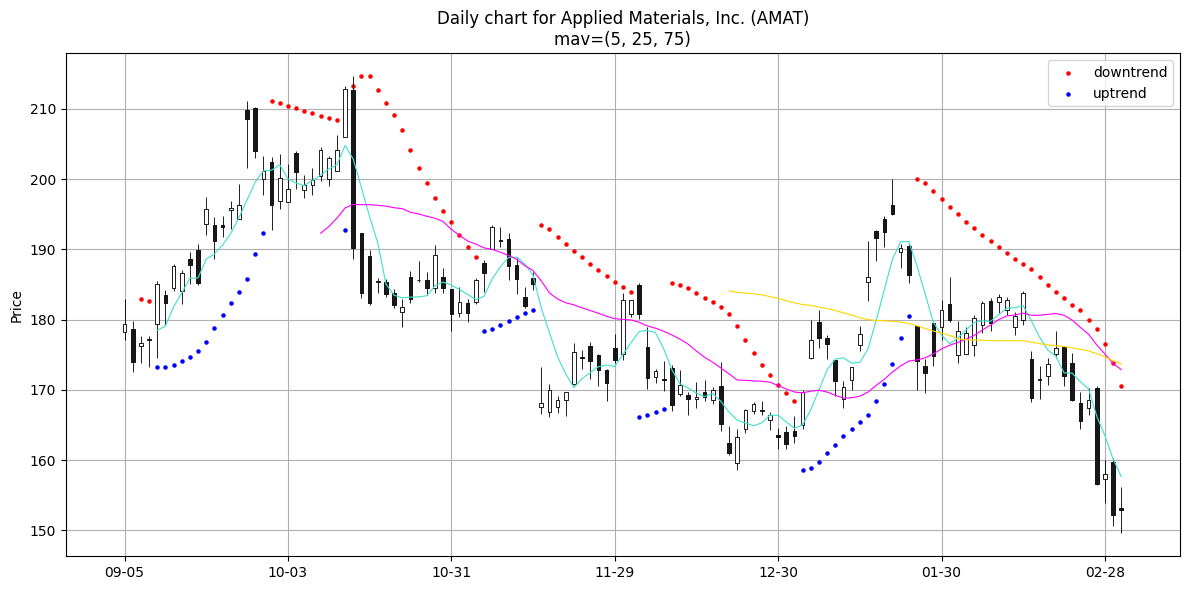

In [3]:
dict_psar = psar(df)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=5,
        color='red',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=5,
        color='blue',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_AMAT.png')
plt.show()

In [4]:
df.tail(2)['Close']

Date
2024-11-11 00:00:00-05:00    188.559998
2024-11-12 00:00:00-05:00    186.699997
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2024-11-11 00:00:00-05:00         NaN
2024-11-12 00:00:00-05:00   -1.860001
Name: Close, dtype: float64